# 🏷️ Part 2.3 - Extract job skills using LLMs

**Author:** Yu Kyung Koh  
**Last Updated:** July 13, 2025  

---

### 🎯 Objective

* Extract job skills from job postings using LLM
* Specifically, I use **Mistral** model via Ollama, which is free to use and fairly high-performing among the free versions. 
* To ensure consistency across extracted skill terms (e.g., "Microsoft Office" vs. "Microsoft Office Suite"), I apply a **harmonization procedure** that clusters semantically similar skills using **sentence embeddings** and **unsupervised clustering.**
  
### 🗂️ Outline
* **Section 1:** Bring in the job posting data
* **Section 2:** Extract skills using the Mistral model via Ollama
* **Section 3:** Harmonize similar skill terms using embedding + clustering
* **Section 4:** Visualize extracted skills

---
## SECTION 1: Bring in the job posting data 

In [3]:
import pandas as pd
import os
import re
import joblib
from tqdm import tqdm
from joblib import Parallel, delayed
import math

import nltk
from nltk.corpus import stopwords
#from rapidfuzz import process, fuzz

In [4]:
# --------------------------------------
# STEP 1: Import data
# --------------------------------------
datadir = '../data/'
jobposting_file = os.path.join(datadir, 'synthetic_job_postings_combined.csv')

posting_df = pd.read_csv(jobposting_file)

In [5]:
posting_df.head()

,job_title,posting_text,sector
0,Sales Development Representative,Join a dynamic team dedicated to driving innov...,sales
1,Healthcare Data Analyst,Join a dynamic team dedicated to improving pat...,healthcare
2,Data Insights Specialist,Join a dynamic team dedicated to unlocking the...,data science
3,Digital Content Strategist,"At our innovative marketing agency, we believe...",marketing
4,Curriculum Developer,Join a dynamic team dedicated to transforming ...,education


In [6]:
# Check how many job postings are in this data 
len(posting_df)

9463

---
## SECTION 2: Extract skills using the Mistral model via Ollama

* Before running below, we need to type `ollama run mistral` in the terminal
* I will only test the LLM approach using the first 250 job postings

In [8]:
# --------------------------------------
# STEP 1: Extract skills using the Mistral model
# --------------------------------------
from ollama import chat

## Limit to the first 250 job postings
sample_posting_df = posting_df.head(250).copy()

## Define blacklist (not skills)
blacklist = {'email', 'phone', 'gmail', 'remote work', 'telephone'}

def post_filter(skills):
    return [s for s in skills if s.lower().strip() not in blacklist]

### Initialize list for storing results
extracted_skills_mistral = []

### Loop through job postings in existing results_df
for desc in tqdm(sample_posting_df["posting_text"]):
    prompt = f"""Extract only the **core job skills** required in the job posting below. 
                Return a **comma-separated list of canonical skill names** (e.g., Python, Excel, Project Management) — **no explanations**.
                
                Include:
                - Technical skills (e.g., SQL, Python, Salesforce, CRM tools)
                - Soft skills (e.g., Communication skills, Problem Solving, Attention to Detail, Leadership)
                
                Strictly DO NOT include:
                - Job titles or company names
                - Communication tools or channels (e.g., Email, Phone, Gmail, Outlook, Zoom, Remote Work)
                - Descriptive phrases or qualifiers (e.g., "experience with", "familiarity with", "ability to use", "skills in")
                - Working conditions, locations, benefits, or DEI-related terms (e.g., Hybrid, Flexible, Diversity, Inclusion)
                
                Return only a concise list of actual skill **names**.
                
                Job posting:
                \"\"\"{desc}\"\"\"
            """
    response = chat(model='mistral', messages=[
        {'role': 'user', 'content': prompt}
    ])
    
    extracted = response['message']['content']

    # Split the comma-separated string and apply post-filter (blacklist)
    raw_skills = [s.strip() for s in extracted.split(',') if s.strip()]
    cleaned_skills = post_filter(raw_skills)
    
    extracted_skills_mistral.append(cleaned_skills)

### Add new column to results_df
sample_posting_df["extracted_skills_mistral"] = extracted_skills_mistral

100%|█████████████████████████████████████████| 250/250 [19:49<00:00,  4.76s/it]


In [9]:
# --------------------------------------
# STEP 2: Examine extracted skills
# --------------------------------------
sample_posting_df.head()

,job_title,posting_text,sector,extracted_skills_mistral
0,Sales Development Representative,Join a dynamic team dedicated to driving innov...,sales,"[Salesforce, Communication skills, Problem Sol..."
1,Healthcare Data Analyst,Join a dynamic team dedicated to improving pat...,healthcare,"[SQL, Excel, Data Visualization (Tableau or Po..."
2,Data Insights Specialist,Join a dynamic team dedicated to unlocking the...,data science,"[SQL, Excel, Tableau (or Power BI), Data Analy..."
3,Digital Content Strategist,"At our innovative marketing agency, we believe...",marketing,"[SEO, Google Analytics, Content Strategy, Digi..."
4,Curriculum Developer,Join a dynamic team dedicated to transforming ...,education,"[Curriculum Development, Instructional Design,..."


In [10]:
sample_posting_df.iloc[1]["posting_text"]

"Join a dynamic team dedicated to improving patient outcomes through insightful data analysis! As a pivotal member of our analytics department, you will dive into healthcare data, interpreting it to inform critical decisions and strategies. Your role involves collecting, cleaning, and analyzing large datasets, collaborating closely with clinical and operational teams to identify trends and areas for improvement. \n\nA strong candidate will have a Bachelor's degree in a related field, along with proficiency in SQL and Excel. Experience with data visualization tools like Tableau or Power BI is a plus. While we're open to fresh perspectives, having at least one year of relevant experience would be beneficial. Ideal candidates will be problem solvers with an analytical mindset and excellent communication skills.\n\nThis is a hybrid position located in Austin, TX, where we pride ourselves on fostering a supportive and inclusive work environment. If you’re ready to make a genuine impact in h

In [11]:
sample_posting_df.iloc[1]["extracted_skills_mistral"]

['SQL',
 'Excel',
 'Data Visualization (Tableau or Power BI)',
 'Problem Solving',
 'Analytical Mindset',
 'Communication Skills']

### 🔷 Comments

* Initial results suggest that the LLM is reasonably effective at extracting job skills from postings.
* However, there are two important caveats:

  1. **Performance and Scalability**
     * Extraction is time-consuming — processing 100 job postings took over 10 minutes.
     * Scaling this to millions of postings may be infeasible with the current setup.
     * A practical alternative for large datasets is to **combine LLMs with machine learning**:
       - Use the LLM to label skill phrases on a small subset of job postings.
       - Train a supervised skill extraction model using these labeled examples.

  2. **Inconsistent Skill Terminology**
     * The same skill can appear under different names across postings (e.g., *Microsoft Office* vs. *Microsoft Office Suite*).
     * To address this, I apply **skill harmonization using embeddings and clustering**.


---
## Section 3: Harmonize similar skill terms using embedding + clustering

In [27]:
# --------------------------------------
# STEP 1: Parse & lowercase extracted_skills_mistral into a flat skill list 
# --------------------------------------
import pandas as pd

# Safely split and normalize the extracted skills
sample_posting_df["parsed_skills"] = sample_posting_df["extracted_skills_mistral"].apply(
    lambda skills: [s.strip().lower() for s in skills] if isinstance(skills, list) else []
)

In [31]:
# --------------------------------------
# STEP 2: Embed all skills
# --------------------------------------
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from collections import Counter

model = SentenceTransformer("all-MiniLM-L6-v2")

# Flatten and lowercase all skills before embedding
all_skills = sorted(set(skill.strip().lower() for skills in sample_posting_df["parsed_skills"] for skill in skills))

# Get embeddings
embeddings = model.encode(all_skills, convert_to_tensor=True)
#embeddings

In [55]:
# --------------------------------------
# STEP 3: Cluster skills using Agglomerative clustering
# --------------------------------------

# Cluster similar skills
clustering = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0.3,  # try between 0.2–0.4
    linkage='average',
    metric='cosine'
)
labels = clustering.fit_predict(embeddings.cpu().numpy())


# Create mapping: label -> canonical skill (e.g., the most frequent in group)
cluster_map = {}
for label in set(labels):
    cluster_skills = [s for s, l in zip(all_skills, labels) if l == label]
    if not cluster_skills:
        continue  # skip empty clusters
    canonical = Counter(cluster_skills).most_common(1)[0][0]  # most frequent
    for s in cluster_skills:
        cluster_map[s] = canonical

In [57]:
# --------------------------------------
# STEP 4: Replace original parsed skills with harmonized version
# --------------------------------------
def harmonize_skills(skill_list):
    return list(set(cluster_map.get(s, s) for s in skill_list))

sample_posting_df["harmonized_skills"] = sample_posting_df["parsed_skills"].apply(harmonize_skills)

---
## Section 4: Visualize extracted skills

In [60]:
# --------------------------------------
# STEP 1: Combine skills by sector
# --------------------------------------
from collections import defaultdict

# Create a dictionary to hold all skills per sector
sector_skills = defaultdict(list)

for _, row in sample_posting_df.iterrows():
    sector = row["sector"]
    skills = row["harmonized_skills"]
    if isinstance(skills, list):  # skip NaNs or non-lists
        sector_skills[sector].extend(skills)

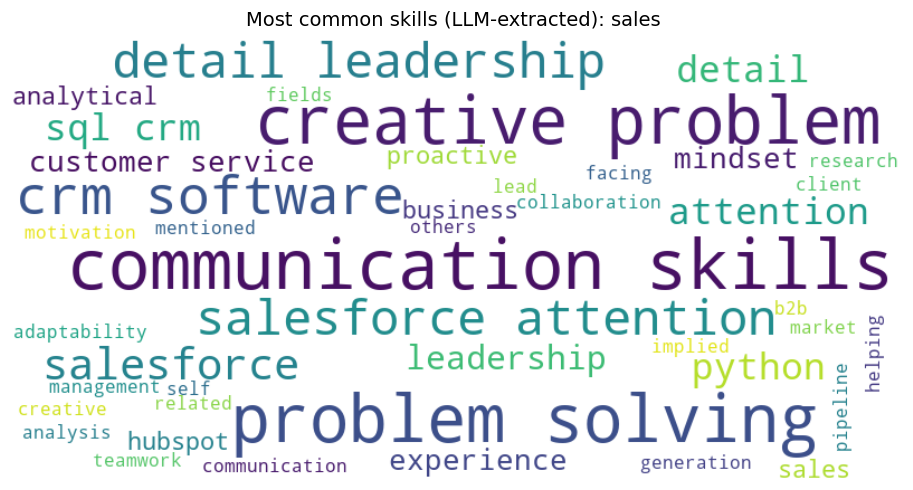

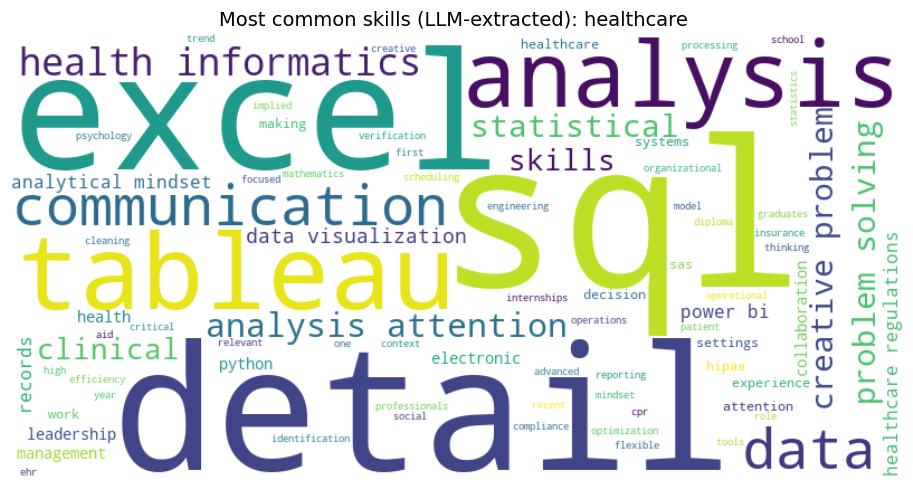

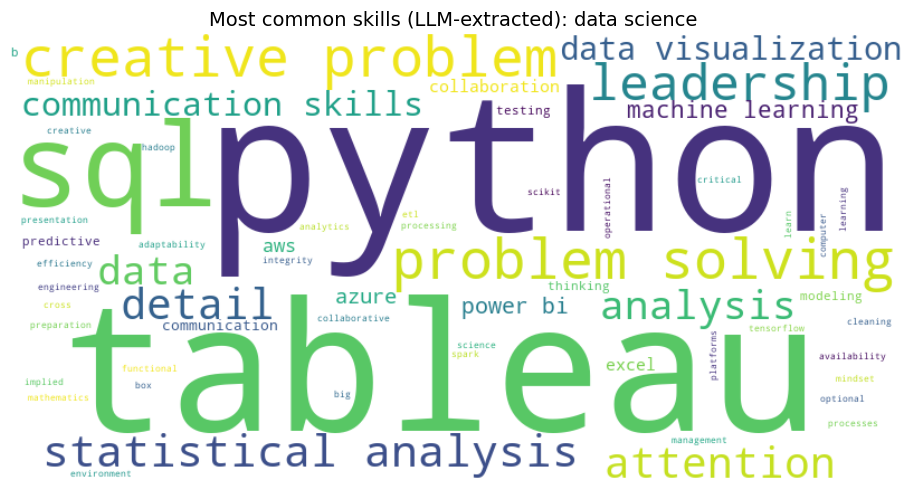

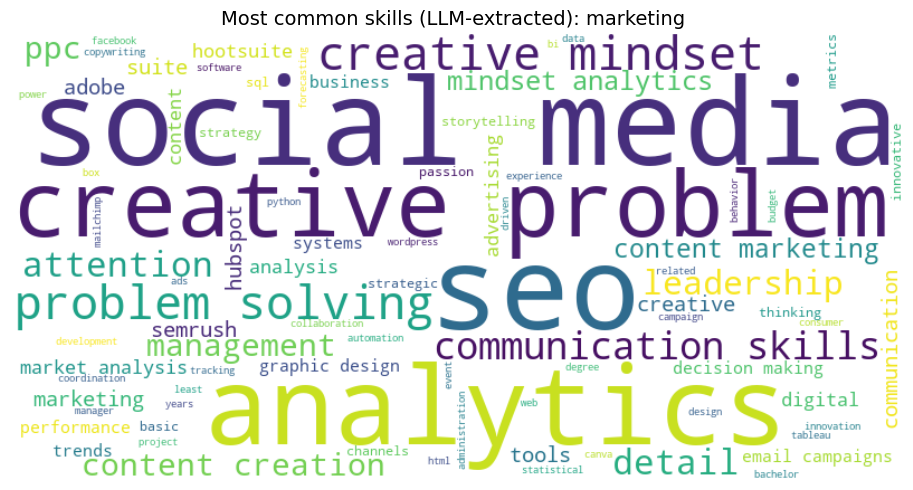

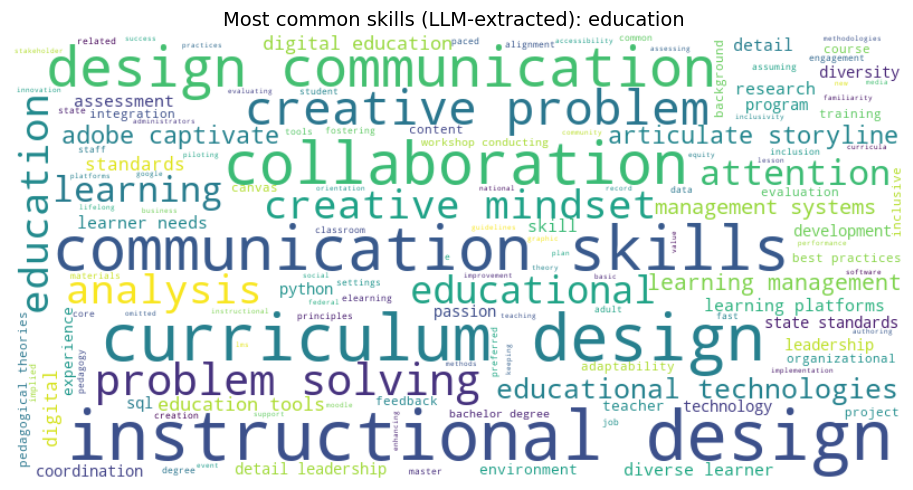

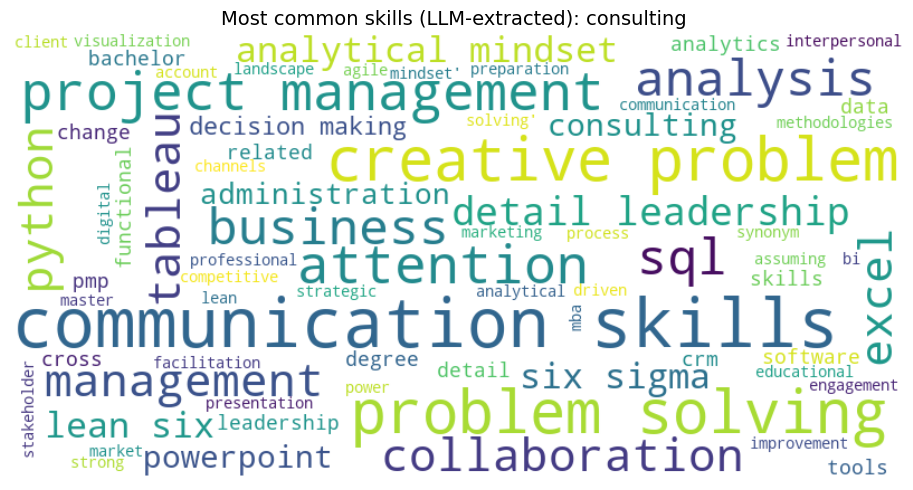

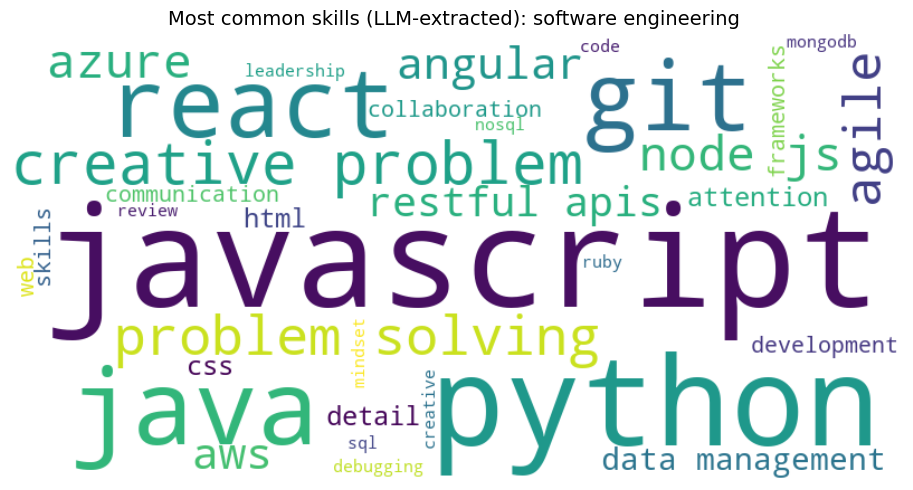

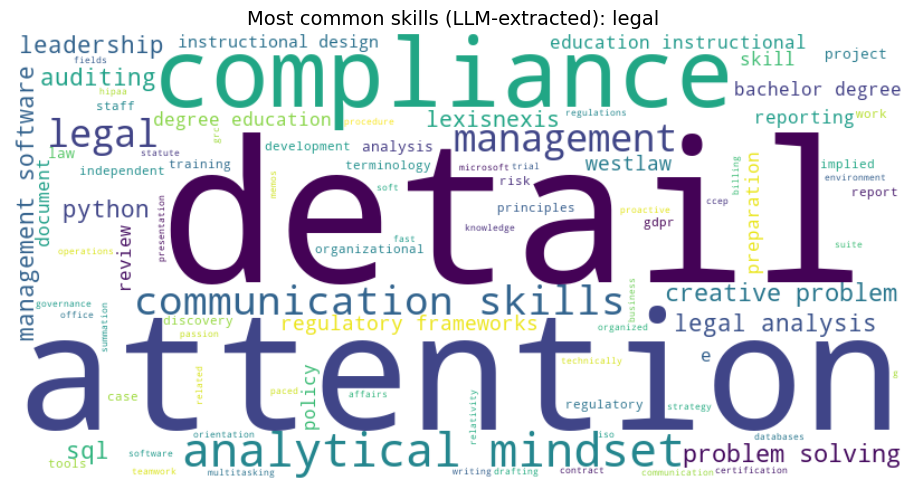

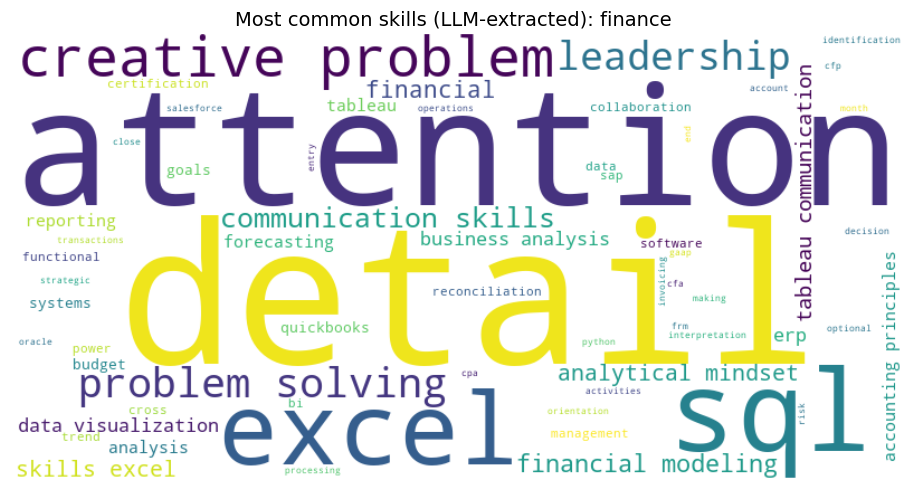

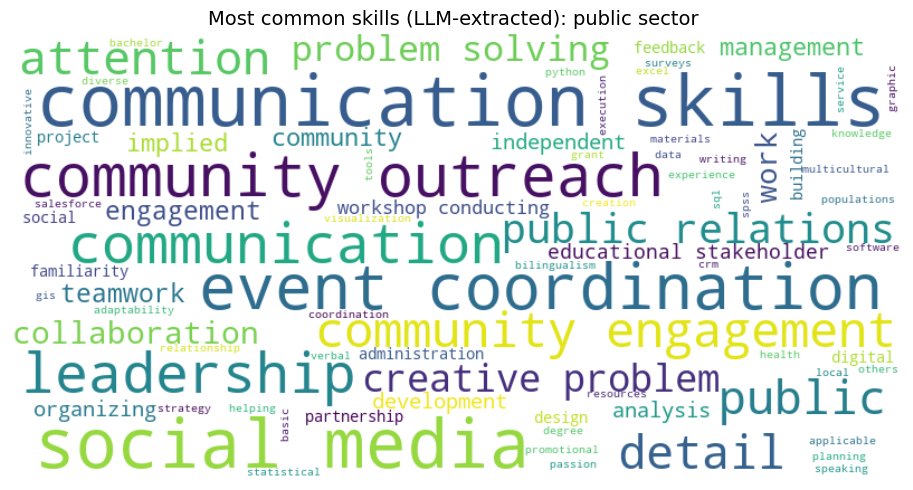

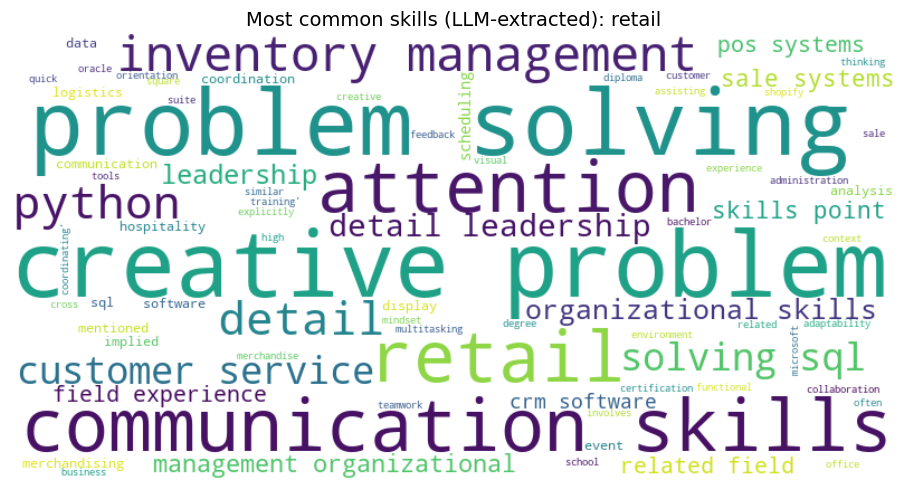

In [62]:
# --------------------------------------
# STEP 2: Generate WordClouds per sector
# --------------------------------------
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for sector, skills in sector_skills.items():
    text = " ".join(skills)

    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most common skills (LLM-extracted): {sector} ", fontsize=14)
    plt.tight_layout()
    plt.show()


### 🔷 Comments on Skill Extraction via LLM

* The word clouds above show that **Mistral LLM** does a reasonably good job at identifying relevant skills from job postings.
* ⚠️ However, there are some caveats:
  * The extraction process is **slow** (taking 20 min for 250 job posting) -- which makes it infeasible to apply to millions of job postings.
  * Some extracted terms are **uninformative** (e.g. applicable, diverse)  

#### ☑️ Future to-do's:
  * Refine the prompt design to better guide the model toward meaningful skill terms
  * Try a better performing model (which could be costly💰)
  * Use LLM extraction on a **small labeled subset** to generate high-quality **training data**.
  * Then train a **supervised model** or implement **rule-based or hybrid** approaches for large-scale inference.